### 모델 학습 및 평가

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 출력문 warning 제거 (무시)
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('./data/okcupid_preprocessed.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  59934 non-null  int64  
 1   sex                         59934 non-null  int64  
 2   orientation                 59934 non-null  int64  
 3   drugs                       59934 non-null  int64  
 4   education                   53310 non-null  float64
 5   height                      59934 non-null  float64
 6   job                         51739 non-null  object 
 7   last_online                 59934 non-null  object 
 8   sign                        59934 non-null  int64  
 9   age                         59934 non-null  int64  
 10  status                      59934 non-null  object 
 11  diet                        35547 non-null  object 
 12  location                    59934 non-null  object 
 13  pets                        400

In [6]:
# last_online 컬럼을 이용해 y 데이터 설정 -> is_churned
df['is_churned'] = np.select(
    [df['last_online'] < '2012-06-18'],     # 2주 동안 미접속 시 이탈 처리
    [1],
    default=0
)
df['is_churned'].value_counts()

is_churned
0    39912
1    20022
Name: count, dtype: int64

In [7]:
# 데이터 분리

X = df[['age_group', 'status_encoding', 'sex', 'orientation',\
        'body_type_average', 'body_type_curvy', 'body_type_fit', 'body_type_slim',\
        'drinks_heavy', 'drinks_moderate', 'drinks_no_drinks', 'drugs',\
        'height', 'job_encoding', 'dogs_encoding', 'cats_encoding',\
        'religion_no_religion', 'religion_religion', 'sign',\
        'smokes_smoke', 'smokes_sometime_smoke']]                       # 총 21개

y = df['is_churned']

In [8]:
# X, y 데이터 SMOTE 적용
from imblearn.over_sampling import SMOTE

print(f'오버샘플링 전 샘플 비율 : {np.bincount(y)}')

smote = SMOTE(random_state=0)
X_resample, y_resample = smote.fit_resample(X, y)

print(f'오버샘플링 후 샘플 비율 : {np.bincount(y_resample)}')

오버샘플링 전 샘플 비율 : [39912 20022]
오버샘플링 후 샘플 비율 : [39912 39912]


In [9]:
# LogisticRegression 모델 학습 및 평가
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, random_state=0, stratify=y_resample)

lr_clf = LogisticRegression(class_weight='balanced')
# lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

print('학습 데이터 점수 :', lr_clf.score(X_train, y_train), '| 평가 데이터 점수 :', lr_clf.score(X_test, y_test))

학습 데이터 점수 : 0.5931048306273803 | 평가 데이터 점수 : 0.5876428141912207


In [10]:
# 데이터 정규화
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# lr_clf = LogisticRegression(class_weight='balanced')
# # lr_clf = LogisticRegression()
# lr_clf.fit(X_train_scaled, y_train)

# print('학습 데이터(정규화) 점수 :', lr_clf.score(X_train_scaled, y_train), '| 평가 데이터(정규화) 점수 :', lr_clf.score(X_test_scaled, y_test))

In [11]:
# 차원 축소(PCA)
# from sklearn.decomposition import PCA

# pca = PCA(n_components=5)   # n_components: 축소할 차원 수 (주성분 수)

# # pca.fit(X)
# pca.fit(X_resample)
# # okcupid_pca = pca.transform(X)
# okcupid_pca = pca.transform(X_resample)

# X_pca = pd.DataFrame(okcupid_pca, columns=['pca_col1', 'pca_col2', 'pca_col3', 'pca_col4', 'pca_col5'])

# X_train, X_test, y_train, y_test = train_test_split(X_pca, y_resample, random_state=0, stratify=y_resample)

# lr_clf = LogisticRegression()
# lr_clf.fit(X_train, y_train)

# print('학습 데이터(PCA) 점수 :', lr_clf.score(X_train, y_train), '| 평가 데이터(PCA) 점수 :', lr_clf.score(X_test, y_test))

In [12]:
# 예측 후 결과 출력
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

y_pred = lr_clf.predict(X_test)
print('예측 정확도 :', accuracy_score(y_test, y_pred))
print('예측 정밀도 :', precision_score(y_test, y_pred))
print('예측 재현율 :', recall_score(y_test, y_pred))
print('예측 f1 score :', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('혼동 행렬')
print(confusion_matrix(y_test, y_pred))

예측 정확도 : 0.5876428141912207
예측 정밀도 : 0.5945303210463734
예측 재현율 : 0.5512126678693124
예측 f1 score : 0.5720526288418535
              precision    recall  f1-score   support

           0       0.58      0.62      0.60      9978
           1       0.59      0.55      0.57      9978

    accuracy                           0.59     19956
   macro avg       0.59      0.59      0.59     19956
weighted avg       0.59      0.59      0.59     19956

혼동 행렬
[[6227 3751]
 [4478 5500]]


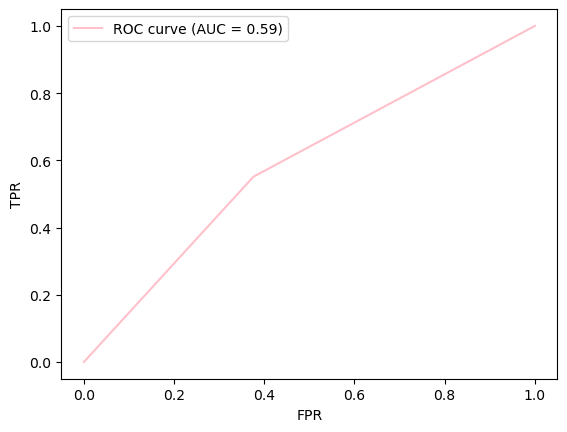

In [13]:
# roc_curve 그래프 시각화
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, color='pink', label=f'ROC curve (AUC = {auc(fpr, tpr):.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [ ]:
# 모델 저장
from joblib import dump
 
dump(lr_clf, 'LogisReg_model.joblib')

['LogisReg_model.joblib']